In [23]:
!pip install facenet-pytorch

In [24]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("frabbisw/facial-age")

print("Path to dataset files:", path)

100%|██████████| 840M/840M [00:11<00:00, 79.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/frabbisw/facial-age/versions/1


In [25]:

import shutil
import os

source_path = path
destination_path = "/content/facial-age"

# Move the dataset
shutil.move(source_path, destination_path)

print("Dataset moved to:", destination_path)
print("Files in new location:", os.listdir(destination_path))

Error: Destination path '/content/facial-age/1' already exists

In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, mean_squared_error
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [28]:

base_path = '/content/facial-age/face_age/'
image_folders = os.listdir(base_path)
# print(image_folders)

age_labels = []
gender_labels = []
image_paths = []
image_names = []

for dir_name in image_folders:
    dir_path = os.path.join(base_path, dir_name)
    image_files = os.listdir(dir_path)
    for img in image_files:
        try:
            age = int(dir_name)
            age_labels.append(age)
            image_names.append(img)
            image_paths.append(os.path.join(base_path,dir_name,img))
        except Exception as e:
            # the dataset folder has another folder with the dataset itself: This will prevent that folder from joining the df
            continue


df = pd.DataFrame({
    'image_path': image_paths,
    'image_name': image_names,
    'age': age_labels
})

df

,image_path,image_name,age
0,/content/facial-age/face_age/033/5326.png,5326.png,33
1,/content/facial-age/face_age/033/215.png,215.png,33
2,/content/facial-age/face_age/033/1494.png,1494.png,33
3,/content/facial-age/face_age/033/2328.png,2328.png,33
4,/content/facial-age/face_age/033/3222.png,3222.png,33
...,...,...,...
9773,/content/facial-age/face_age/083/6177.png,6177.png,83
9774,/content/facial-age/face_age/083/5401.png,5401.png,83
9775,/content/facial-age/face_age/083/1939.png,1939.png,83
9776,/content/facial-age/face_age/083/8646.png,8646.png,83


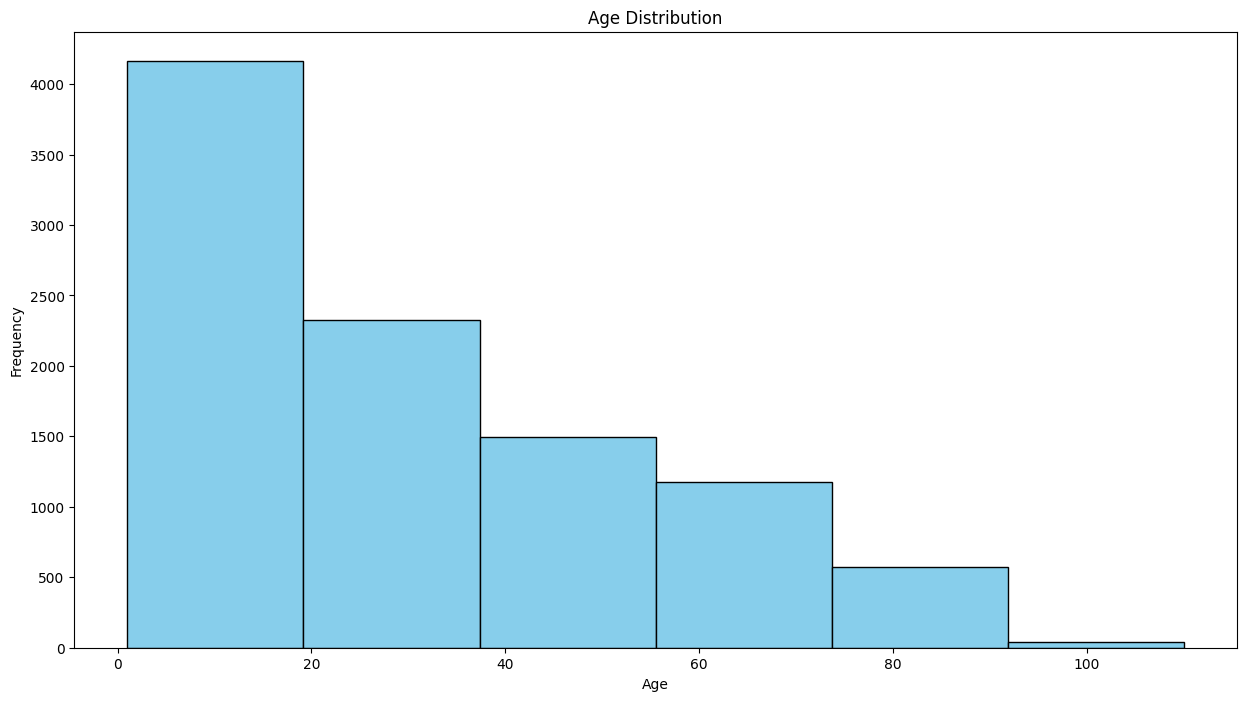

In [29]:
plt.figure(figsize=(15, 8))
plt.hist(df['age'], bins=6, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()


In [30]:
df['Age_Group'] = pd.qcut(df['age'], q=4, labels=range(0,4))
df['Age_Interval'] = pd.qcut(df['age'], q=4)

df

,image_path,image_name,age,Age_Group,Age_Interval
0,/content/facial-age/face_age/033/5326.png,5326.png,33,2,"(25.0, 49.0]"
1,/content/facial-age/face_age/033/215.png,215.png,33,2,"(25.0, 49.0]"
2,/content/facial-age/face_age/033/1494.png,1494.png,33,2,"(25.0, 49.0]"
3,/content/facial-age/face_age/033/2328.png,2328.png,33,2,"(25.0, 49.0]"
4,/content/facial-age/face_age/033/3222.png,3222.png,33,2,"(25.0, 49.0]"
...,...,...,...,...,...
9773,/content/facial-age/face_age/083/6177.png,6177.png,83,3,"(49.0, 110.0]"
9774,/content/facial-age/face_age/083/5401.png,5401.png,83,3,"(49.0, 110.0]"
9775,/content/facial-age/face_age/083/1939.png,1939.png,83,3,"(49.0, 110.0]"
9776,/content/facial-age/face_age/083/8646.png,8646.png,83,3,"(49.0, 110.0]"


In [31]:
df['Age_Interval'].unique()

[(25.0, 49.0], (0.999, 7.0], (7.0, 25.0], (49.0, 110.0]]
Categories (4, interval[float64, right]): [(0.999, 7.0] < (7.0, 25.0] < (25.0, 49.0] <
                                           (49.0, 110.0]]

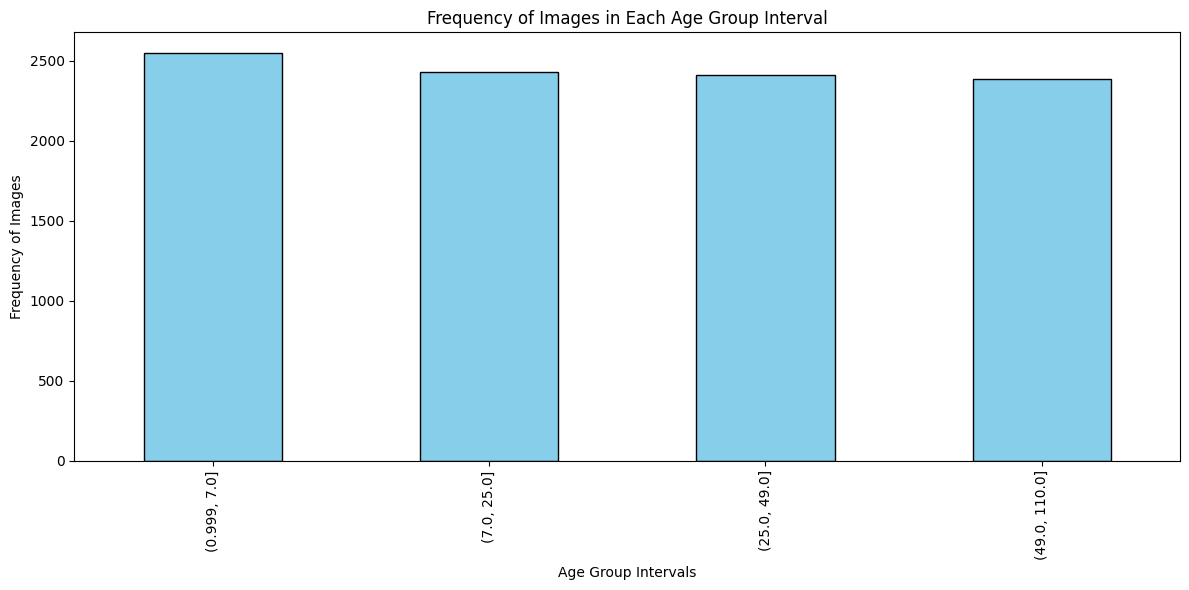

In [32]:
age_group_counts = df['Age_Interval'].value_counts().sort_index()

# Plotting the intervals and their frequencies
plt.figure(figsize=(12, 6))
age_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Set labels and title
plt.xlabel("Age Group Intervals")
plt.ylabel("Frequency of Images")
plt.title("Frequency of Images in Each Age Group Interval")

interval_counts = df['Age_Group'].value_counts().sort_index()
interval_labels = [f"{int(interval)}" for interval in interval_counts.index]

plt.tight_layout()
plt.show()

In [33]:
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os


transform_pipeline = transforms.Compose([
    transforms.ToTensor(),                     # Convert image to tensor
    # transforms.ToPILImage(),                   # Convert OpenCV image (NumPy array) to PIL format
    transforms.RandomHorizontalFlip(p=0.5),    # 50% chance of horizontal flip
    transforms.RandomRotation(30),             # Random rotation within ±30 degrees
    transforms.Resize((224, 224)),             # Resize to desired input size (224x224 here)
    # transforms.Normalize([0.5], [0.5])         # Normalize; mean and std of 0.5 for grayscale
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ColorJitter(brightness=0.1, contrast=0.1)
])

In [34]:
def test_processing(df):
    brightImages = []
    smallImages = []
    dullImages = []

    blist = []
    varList = []
    for idx in range(len(df)):
        img_path = df.iloc[idx]['image_path']
        img_path = os.path.join(img_path)
        label = df.iloc[idx]['Age_Group']  # Age group label for classification

        image = Image.open(img_path)
        img_array = np.array(image)

        brightness = np.mean(img_array)
        blist.append(brightness)
        if brightness < 50 or brightness > 225:
            brightImages.append(idx)

        if img_array.shape[0] < 50 or img_array.shape[1] < 50:  # Example minimum size
            smallImages.append(idx)

        gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        variance = cv2.Laplacian(gray, cv2.CV_64F).var()
        varList.append(variance)
        if variance < 22.814826998125:
            dullImages.append(idx)


    print(brightImages)
    print(smallImages)
    print(dullImages)
    return blist, varList, dullImages


blist, varlist, dullImages = test_processing(df)



[2595, 2768, 3708, 3763, 5647, 5807, 5924, 5952, 6099, 6529, 7588, 7626, 8965]
[]
[2, 9, 10, 11, 12, 14, 16, 20, 24, 25, 27, 29, 30, 32, 34, 35, 39, 42, 45, 57, 65, 67, 76, 85, 88, 91, 95, 99, 104, 106, 108, 111, 115, 116, 120, 122, 138, 150, 161, 163, 166, 171, 172, 174, 179, 186, 192, 203, 208, 209, 211, 226, 229, 234, 241, 244, 253, 256, 261, 269, 273, 277, 278, 280, 283, 291, 294, 295, 302, 306, 308, 317, 318, 328, 357, 363, 368, 377, 391, 392, 401, 408, 410, 413, 419, 421, 425, 432, 437, 442, 456, 460, 463, 465, 466, 467, 470, 487, 494, 507, 511, 512, 525, 527, 532, 535, 542, 545, 552, 556, 560, 561, 565, 570, 576, 578, 590, 594, 597, 598, 600, 606, 609, 611, 612, 613, 614, 616, 617, 618, 621, 624, 628, 630, 634, 636, 639, 640, 644, 653, 654, 655, 659, 660, 671, 674, 679, 680, 683, 685, 687, 691, 692, 698, 700, 702, 706, 708, 709, 710, 712, 714, 716, 719, 720, 722, 723, 726, 727, 730, 733, 749, 757, 758, 759, 760, 765, 768, 770, 777, 788, 792, 804, 808, 813, 814, 816, 818, 835, 83

In [35]:

#  brightness
print("Mean Brightness: " + str(np.mean(blist)))
print("Minimum Brightness: " + str(np.min(blist)))
print("Maximum Brightness: " + str(np.max(blist)))
print("Median Brightness: " + str(np.median(blist)))

Q1_brightness = np.percentile(blist, 25)
Q3_brightness = np.percentile(blist, 75)
print("First Quartile (Q1) Brightness: " + str(Q1_brightness))
print("Third Quartile (Q3) Brightness: " + str(Q3_brightness))

print ("---------------------------------------------------------------")
# variance
print("Mean Variance: " + str(np.mean(varlist)))
print("Minimum Variance: " + str(np.min(varlist)))
print("Maximum Variance: " + str(np.max(varlist)))
print("Median Variance: " + str(np.median(varlist)))

Q1_variance = np.percentile(varlist, 25)
Q3_variance = np.percentile(varlist, 75)
print("First Quartile (Q1) Variance: " + str(Q1_variance))
print("Third Quartile (Q3) Variance: " + str(Q3_variance))

Mean Brightness: 131.10234516772346
Minimum Brightness: 34.64850833333333
Maximum Brightness: 239.409775
Median Brightness: 130.06289583333336
First Quartile (Q1) Brightness: 110.6769
Third Quartile (Q3) Brightness: 150.6685875
---------------------------------------------------------------
Mean Variance: 87.78310343591954
Minimum Variance: 4.020422824375
Maximum Variance: 4732.489427777499
Median Variance: 41.339805423437504
First Quartile (Q1) Variance: 22.814826998125
Third Quartile (Q3) Variance: 92.109335073125


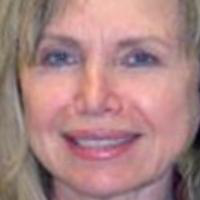

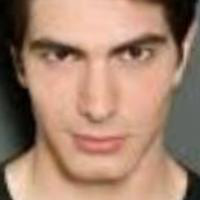

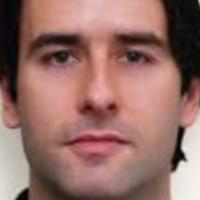

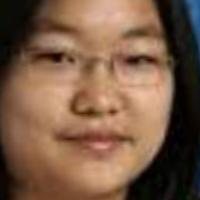

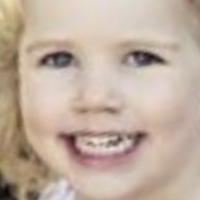

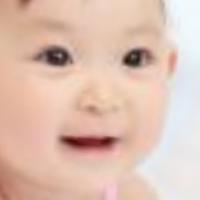

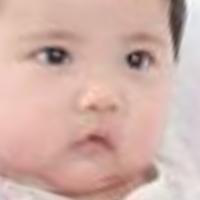

In [36]:
display(Image.open(df.iloc[1812]['image_path']))
display(Image.open(df.iloc[3216]['image_path']))


display(Image.open(df.iloc[0]['image_path']))
display(Image.open(df.iloc[9236]['image_path']))
display(Image.open(df.iloc[8612]['image_path']))
display(Image.open(df.iloc[6745]['image_path']))
display(Image.open(df.iloc[7016]['image_path']))




In [37]:

model = models.vgg16(pretrained=True)


num_classes = 5

# model.classifier[6] = nn.Linear(4096, num_classes)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:

class facialAge(Dataset):
    def __init__(self, df, transform=None, preprocess=None):
        self.df = df
        self.transform = transform
        self.preprocess = preprocess

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        img_path = os.path.join(img_path)
        label = self.df.iloc[idx]['Age_Group']  # Age group label for classification

        image = Image.open(img_path)
        if self.preprocess:
            image = self.preprocess(image)
        if self.transform:
            image = self.transform(image)

        return image, label



train_df, test_df = train_test_split(df, test_size=0.2, random_state=21)

train_dataset = facialAge(train_df, transform_pipeline)
test_dataset = facialAge(test_df, transform_pipeline)

train_df

,image_path,image_name,age,Age_Group,Age_Interval
6508,/content/facial-age/face_age/001/4339.png,4339.png,1,0,"(0.999, 7.0]"
5595,/content/facial-age/face_age/015/5683.png,5683.png,15,1,"(7.0, 25.0]"
6565,/content/facial-age/face_age/001/7326.png,7326.png,1,0,"(0.999, 7.0]"
279,/content/facial-age/face_age/006/4620.png,4620.png,6,0,"(0.999, 7.0]"
4218,/content/facial-age/face_age/024/2948.png,2948.png,24,1,"(7.0, 25.0]"
...,...,...,...,...,...
9336,/content/facial-age/face_age/027/4496.png,4496.png,27,2,"(25.0, 49.0]"
48,/content/facial-age/face_age/007/4466.png,4466.png,7,0,"(0.999, 7.0]"
8964,/content/facial-age/face_age/075/1254.png,1254.png,75,3,"(49.0, 110.0]"
5944,/content/facial-age/face_age/021/8342.png,8342.png,21,1,"(7.0, 25.0]"


In [39]:
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support


dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

import torch
import torch.optim as optim

learning_rates = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
# Set up loss function and optimizer
test_accuracies_across_learning_rates = []
for lr in learning_rates:

    model = models.vgg16(pretrained=True)


    num_classes = 5

    # model.classifier[6] = nn.Linear(4096, num_classes)
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = model.to(device)

    print("Learning Rate: " + str(lr))
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    num_epochs = 10
    device ='cuda'

    for epoch in range(num_epochs):
        total_train = 0
        correct_train = 0
        model.train()
        running_loss = 0.0

        for batch in dataloader:
            images, labels = batch  # Unpack images and labels
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            running_loss += loss.item()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_accuracy = 100 * correct_train / total_train

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, Train Accuracy: {train_accuracy}")


    model.eval()

    # Initialize variables to track performance
    correct = 0
    total = 0
    test_loss = 0.0

    all_labels = []
    all_predictions = []

    # Disable gradient computation for testing
    with torch.no_grad():
        for batch in test_dataloader:  # Assuming test_dataloader is your DataLoader for the test set
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predicted class by taking the class with the highest score
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append to lists (convert to CPU and detach from computation graph)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average loss and accuracy
    average_test_loss = test_loss / len(test_dataloader)
    accuracy = 100 * correct / total
    test_accuracies_across_learning_rates.append(accuracy)
    print(f'Test Loss: {average_test_loss:.4f}, Accuracy: {accuracy:.2f}%')





    conf_matrix = confusion_matrix(all_labels, all_predictions)



    precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_predictions)

    print("\nPrecision per class:", precision)

    print("Recall per class:", recall)

    print("F1-score per class:", f1_score)

    print("Samples per class:", support)

    print("----------------------------------------------------------------------")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Learning Rate: 0.001
Epoch [1/10], Loss: 1.5371, Train Accuracy: 26.246484275121453
Epoch [2/10], Loss: 1.3943, Train Accuracy: 25.581692661723345
Epoch [3/10], Loss: 1.3922, Train Accuracy: 25.095883405778572
Epoch [4/10], Loss: 1.3927, Train Accuracy: 24.495014062899514
Epoch [5/10], Loss: 1.3926, Train Accuracy: 24.67399642035285
Epoch [6/10], Loss: 1.3897, Train Accuracy: 25.44106366658144
Epoch [7/10], Loss: 1.3895, Train Accuracy: 25.530554845308107
Epoch [8/10], Loss: 1.3915, Train Accuracy: 24.610074149833803
Epoch [9/10], Loss: 1.3888, Train Accuracy: 26.144208642290973
Epoch [10/10], Loss: 1.3899, Train Accuracy: 25.517770391204294
Test Loss: 1.3882, Accuracy: 23.67%

Precision per class: [0.         0.         0.23670757 0.        ]
Recall per class: [0. 0. 1. 0.]
F1-score per class: [0.         0.         0.38280281 0.        ]
Samples per class: [512 482 463 499]
----------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Learning Rate: 0.0001
Epoch [1/10], Loss: 0.8761, Train Accuracy: 61.92789567885451
Epoch [2/10], Loss: 0.6378, Train Accuracy: 72.5262081309128
Epoch [3/10], Loss: 0.5739, Train Accuracy: 75.72232165686525
Epoch [4/10], Loss: 0.5082, Train Accuracy: 78.43262592687292
Epoch [5/10], Loss: 0.4630, Train Accuracy: 80.79774993607774
Epoch [6/10], Loss: 0.4315, Train Accuracy: 82.37023779084633
Epoch [7/10], Loss: 0.3951, Train Accuracy: 84.00664791613399
Epoch [8/10], Loss: 0.3737, Train Accuracy: 84.49245717207876
Epoch [9/10], Loss: 0.3499, Train Accuracy: 85.42572232165686
Epoch [10/10], Loss: 0.3242, Train Accuracy: 87.11327026335975
Test Loss: 0.5216, Accuracy: 79.35%

Precision per class: [0.95705521 0.68369028 0.68865435 0.84823285]
Recall per class: [0.9140625  0.86099585 0.5637149  0.81763527]
F1-score per class: [0.93506494 0.76216713 0.61995249 0.83265306]
Samples per class: [512 482 463 499]
----------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Learning Rate: 1e-05
Epoch [1/10], Loss: 1.0629, Train Accuracy: 53.11940680132958
Epoch [2/10], Loss: 0.7639, Train Accuracy: 67.25901304014319
Epoch [3/10], Loss: 0.6823, Train Accuracy: 70.78752237279468
Epoch [4/10], Loss: 0.6227, Train Accuracy: 73.48504218869854
Epoch [5/10], Loss: 0.5893, Train Accuracy: 75.21094349271286
Epoch [6/10], Loss: 0.5567, Train Accuracy: 76.42546663257478
Epoch [7/10], Loss: 0.5226, Train Accuracy: 78.18972129890054
Epoch [8/10], Loss: 0.4984, Train Accuracy: 79.11020199437483
Epoch [9/10], Loss: 0.4717, Train Accuracy: 79.91562260291485
Epoch [10/10], Loss: 0.4479, Train Accuracy: 81.23242137560726
Test Loss: 0.5286, Accuracy: 77.91%

Precision per class: [0.9        0.71485149 0.63600783 0.8804878 ]
Recall per class: [0.93164062 0.74896266 0.70194384 0.72344689]
F1-score per class: [0.91554702 0.73150963 0.66735113 0.79427943]
Samples per class: [512 482 463 499]
----------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Learning Rate: 1e-06
Epoch [1/10], Loss: 1.5273, Train Accuracy: 27.652774226540526
Epoch [2/10], Loss: 1.3465, Train Accuracy: 38.05931986704168
Epoch [3/10], Loss: 1.1928, Train Accuracy: 46.52262848376375
Epoch [4/10], Loss: 1.0735, Train Accuracy: 53.05548453081053
Epoch [5/10], Loss: 0.9988, Train Accuracy: 56.379442597801074
Epoch [6/10], Loss: 0.9491, Train Accuracy: 58.399386346203016
Epoch [7/10], Loss: 0.8974, Train Accuracy: 61.63385323446689
Epoch [8/10], Loss: 0.8716, Train Accuracy: 62.23472257734595
Epoch [9/10], Loss: 0.8413, Train Accuracy: 64.08846842239836
Epoch [10/10], Loss: 0.8173, Train Accuracy: 64.94502684735362
Test Loss: 0.7526, Accuracy: 68.25%

Precision per class: [0.8458498  0.57170923 0.56091954 0.73517787]
Recall per class: [0.8359375  0.60373444 0.52699784 0.74549098]
F1-score per class: [0.84086444 0.58728557 0.54342984 0.74029851]
Samples per class: [512 482 463 499]
----------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Learning Rate: 1e-07
Epoch [1/10], Loss: 1.6239, Train Accuracy: 23.996420352850933
Epoch [2/10], Loss: 1.5870, Train Accuracy: 26.668371260547175
Epoch [3/10], Loss: 1.5584, Train Accuracy: 27.934032216824342
Epoch [4/10], Loss: 1.5281, Train Accuracy: 29.378675530554844
Epoch [5/10], Loss: 1.5097, Train Accuracy: 29.03349526975198
Epoch [6/10], Loss: 1.4793, Train Accuracy: 31.34748146254155
Epoch [7/10], Loss: 1.4648, Train Accuracy: 32.52365124009205
Epoch [8/10], Loss: 1.4396, Train Accuracy: 33.725389925850166
Epoch [9/10], Loss: 1.4171, Train Accuracy: 35.15724878547686
Epoch [10/10], Loss: 1.4029, Train Accuracy: 36.58910764510355
Test Loss: 1.3571, Accuracy: 44.02%

Precision per class: [0.52896341 0.31398417 0.33891213 0.52595937]
Recall per class: [0.67773438 0.24688797 0.34989201 0.46693387]
F1-score per class: [0.59417808 0.27642276 0.34431456 0.49469214]
Samples per class: [512 482 463 499]
----------------------------------------------------------------------


In [40]:
torch.save(model.state_dict(), 'vgg-16-facial-age.pth')